In [1]:
import numpy as np
import numpyro
import numpyro.distributions as dist
from numpyro.infer.reparam import TransformReparam, LocScaleReparam
from numpyro.distributions.transforms import AffineTransform, OrderedTransform
from numpyro.infer import MCMC, NUTS, Predictive, SVI, Trace_ELBO, log_likelihood
from numpyro.infer.autoguide import AutoLaplaceApproximation
import numpyro.optim as optim
from numpyro import handlers
from numpyro.handlers import mask
import jax
from jax.numpy import DeviceArray
import jax.numpy as jnp
from jax import random, lax
from jax import nn as jnn
from jax.scipy.special import expit
import pandas as pd
import matplotlib.pyplot as plt
import arviz as az
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, roc_auc_score
from sklearn.preprocessing import StandardScaler, OrdinalEncoder

/home/pasbury/neg-price-model/venv/lib/python3.8/site-packages/jax/experimental/optimizers.py:28: FutureWarning: jax.experimental.optimizers is deprecated, import jax.example_libraries.optimizers instead
  warnings.warn('jax.experimental.optimizers is deprecated, '
/home/pasbury/neg-price-model/venv/lib/python3.8/site-packages/jax/experimental/stax.py:28: FutureWarning: jax.experimental.stax is deprecated, import jax.example_libraries.stax instead
  warnings.warn('jax.experimental.stax is deprecated, '


In [2]:
d = pd.read_csv('data/reedfrogs.csv', sep=';')

In [5]:
d.describe(include='all')

,density,pred,size,surv,propsurv
count,48.000000,48,48,48.000000,48.000000
unique,NaN,2,2,NaN,NaN
top,NaN,no,big,NaN,NaN
freq,NaN,24,24,NaN,NaN
mean,23.333333,NaN,NaN,16.312500,0.721607
std,10.382746,NaN,NaN,9.884775,0.266416
min,10.000000,NaN,NaN,4.000000,0.114286
25%,10.000000,NaN,NaN,9.000000,0.496429
50%,25.000000,NaN,NaN,12.500000,0.885714
75%,35.000000,NaN,NaN,23.000000,0.920000


In [6]:
d.sample(5)

,density,pred,size,surv,propsurv
36,35,no,small,31,0.885714
46,35,pred,small,31,0.885714
2,10,no,big,7,0.700000
30,25,pred,small,8,0.320000
32,35,no,big,34,0.971429


In [13]:
def model(row, density, surv):
    n_row = row.shape[0]
    alpha = numpyro.sample("row_intercept", dist.Normal(0,1.5).expand([n_row,]))
    #alpha = numpyro.sample("row_intercept", dist.Normal(0,1.5).expand([48,]))
    p = expit(alpha[row])
    surv = numpyro.sample("survived", dist.Binomial(density,p), obs=surv)
    
m13_1 = MCMC(NUTS(model), num_warmup=500, num_samples=500)
m13_1.run(random.PRNGKey(0), row=d.index.values, density=d.density.values, surv=d.surv.values)
m13_1.print_summary()



sample: 100%|██████████| 1000/1000 [00:03<00:00, 285.88it/s, 7 steps of size 4.41e-01. acc. prob=0.89]



                       mean       std    median      5.0%     95.0%     n_eff     r_hat
 row_intercept[0]      1.74      0.78      1.70      0.50      3.10    649.05      1.01
 row_intercept[1]      2.40      0.94      2.38      0.87      3.83    561.79      1.01
 row_intercept[2]      0.71      0.68      0.69     -0.49      1.73    730.98      1.00
 row_intercept[3]      2.41      0.83      2.35      1.11      3.66    662.06      1.00
 row_intercept[4]      1.70      0.71      1.61      0.67      2.99    866.90      1.00
 row_intercept[5]      1.74      0.76      1.68      0.54      2.94    851.08      1.00
 row_intercept[6]      2.42      0.93      2.32      0.83      3.84    635.44      1.00
 row_intercept[7]      1.73      0.77      1.65      0.64      3.11    496.03      1.00
 row_intercept[8]     -0.36      0.57     -0.37     -1.29      0.47    966.46      1.00
 row_intercept[9]      1.70      0.76      1.68      0.46      2.89    668.53      1.00
row_intercept[10]      0.73    

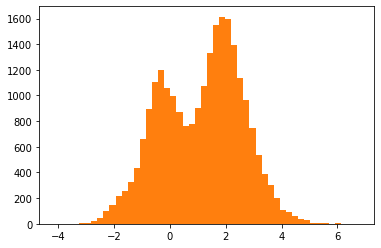

In [46]:
az_13_1 = az.from_numpyro(m13_1)
a = az_13_1['posterior']['row_intercept'].squeeze()
plt.hist(a.mean(axis=0), bins=5)
_ = plt.hist(a.values.flatten(), bins = 50)

In [47]:
def model(row, density, surv):
    n_row = row.shape[0]
    alpha_loc = numpyro.sample("alpha_loc", dist.Normal(0,1.5))
    alpha_scale = numpyro.sample("alpha_scale", dist.Exponential(1))
    alpha = numpyro.sample("row_intercept", dist.Normal(alpha_loc,alpha_scale).expand([n_row,]))

    p = expit(alpha[row])
    surv = numpyro.sample("survived", dist.Binomial(density,p), obs=surv)
    
m13_2 = MCMC(NUTS(model), num_warmup=500, num_samples=500)
m13_2.run(random.PRNGKey(0), row=d.index.values, density=d.density.values, surv=d.surv.values)
m13_2.print_summary()


sample: 100%|██████████| 1000/1000 [00:03<00:00, 255.15it/s, 7 steps of size 4.63e-01. acc. prob=0.87]



                       mean       std    median      5.0%     95.0%     n_eff     r_hat
        alpha_loc      1.35      0.26      1.33      0.93      1.77    465.83      1.00
      alpha_scale      1.62      0.21      1.60      1.29      1.97    252.78      1.00
 row_intercept[0]      2.09      0.84      2.01      0.63      3.36    721.85      1.00
 row_intercept[1]      3.07      1.10      3.00      1.12      4.61    531.62      1.00
 row_intercept[2]      1.01      0.70      0.99     -0.14      2.08    397.82      1.00
 row_intercept[3]      3.07      1.11      2.98      1.29      4.75    502.45      1.00
 row_intercept[4]      2.13      0.81      2.06      0.78      3.41    613.88      1.00
 row_intercept[5]      2.22      0.98      2.07      0.82      3.86    409.11      1.01
 row_intercept[6]      3.09      1.14      2.94      1.33      4.86    515.89      1.00
 row_intercept[7]      2.15      0.86      2.10      0.78      3.58    573.56      1.00
 row_intercept[8]     -0.21    

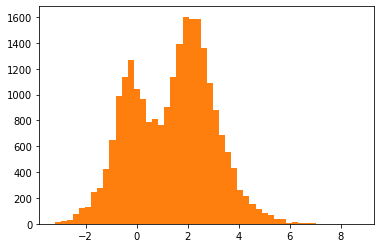

In [48]:
az_13_2 = az.from_numpyro(m13_2)
a = az_13_2['posterior']['row_intercept'].squeeze()
plt.hist(a.mean(axis=0), bins=5)
_ = plt.hist(a.values.flatten(), bins = 50)

In [49]:
# logprob1= log_likelihood(m1.model, samples1, d.W.values, d.S.values, d.F.values)
# az1 = az.from_dict({}, log_likelihood={"blooms": logprob1["blooms"][None, ...]})

# logprob2= log_likelihood(m2.model, samples2, d.B.values, d.W.values, d.S.values, d.F.values)
# az2 = az.from_dict({}, log_likelihood={"blooms": logprob2["blooms"][None, ...]})

compare = az.compare({"m13_1 Varying imntercepts": az_13_1, "m13_2 Hierarchical": az_13_2}, ic="waic", scale="deviance")
compare

/home/pasbury/neg-price-model/venv/lib/python3.8/site-packages/arviz/stats/stats.py:1458: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/home/pasbury/neg-price-model/venv/lib/python3.8/site-packages/arviz/stats/stats.py:1458: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
m13_2 Hierarchical,0,202.040299,21.761850,0.000000,1.0,7.590102,0.000000,True,deviance
m13_1 Varying imntercepts,1,216.093825,26.269321,14.053527,0.0,4.978521,4.791401,True,deviance


## Simulation 

In [88]:
a_bar = 1.5
sigma = 1.5
num_ponds = 60
Ni = jnp.repeat(jnp.array([5, 10, 25, 35]), 15)

In [89]:
Ni

DeviceArray([ 5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,
             10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
             25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25,
             35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35],            dtype=int32)

In [90]:
a_pond = dist.Normal(a_bar, sigma).expand([num_ponds,]).sample(random.PRNGKey(42))

In [91]:
dsim = pd.DataFrame(data = jnp.stack((Ni, a_pond), axis=1), columns = ['Ni', 'a_pond'])

In [92]:
dsim['Si'] = dist.BinomialLogits(a_pond, Ni).sample(random.PRNGKey(24))

In [93]:
dsim['p_nopool'] = dsim['Si'] / dsim['Ni']

In [94]:
dsim.sample(5)

,Ni,a_pond,Si,p_nopool
28,10.0,3.018501,10,1.000000
55,35.0,0.897908,23,0.657143
6,5.0,4.148145,5,1.000000
14,5.0,1.349992,2,0.400000
51,35.0,1.276490,32,0.914286


In [95]:
def model(row, density, surv):
    n_row = row.shape[0]
    alpha_loc = numpyro.sample("alpha_loc", dist.Normal(0,1.5))
    alpha_scale = numpyro.sample("alpha_scale", dist.Exponential(1))
    alpha = numpyro.sample("row_intercept", dist.Normal(alpha_loc,alpha_scale).expand([n_row,]))

    p = expit(alpha[row])
    surv = numpyro.sample("survived", dist.Binomial(density,p), obs=surv)
    
m13_3 = MCMC(NUTS(model), num_warmup=500, num_samples=500)
m13_3.run(random.PRNGKey(0), row=dsim.index.values, density=dsim.Ni.values, surv=dsim.Si.values)
m13_3.print_summary()


sample: 100%|██████████| 1000/1000 [00:07<00:00, 135.14it/s, 7 steps of size 4.24e-01. acc. prob=0.88]



                       mean       std    median      5.0%     95.0%     n_eff     r_hat
        alpha_loc      1.38      0.25      1.38      0.95      1.76    291.71      1.01
      alpha_scale      1.68      0.24      1.66      1.31      2.03    140.45      1.00
 row_intercept[0]     -0.75      0.90     -0.74     -2.31      0.61    675.56      1.00
 row_intercept[1]      1.57      1.02      1.50     -0.05      3.21    809.24      1.00
 row_intercept[2]      0.03      0.82      0.02     -1.33      1.39    425.18      1.00
 row_intercept[3]      0.77      0.88      0.74     -0.70      2.12    590.22      1.00
 row_intercept[4]      1.54      1.00      1.51     -0.05      3.02    655.17      1.00
 row_intercept[5]      2.72      1.21      2.59      0.82      4.63    546.68      1.00
 row_intercept[6]      2.69      1.23      2.53      0.77      4.69    435.27      1.00
 row_intercept[7]      2.72      1.32      2.58      0.35      4.49    512.21      1.00
 row_intercept[8]      0.73    

In [96]:
post = m13_3.get_samples()

In [97]:
dsim['p_partpool'] = expit(post['row_intercept']).mean(axis = 0)

In [98]:
dsim['p_true'] = expit(dsim['a_pond'].values)

<AxesSubplot:xlabel='p_true', ylabel='p_partpool'>

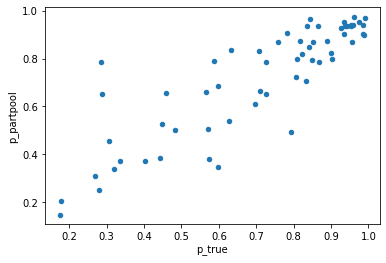

In [99]:
dsim.plot.scatter('p_true', 'p_partpool')

In [100]:
dsim['e_nopool'] = np.abs(dsim.p_nopool - dsim.p_true)
dsim['e_partpool'] = np.abs(dsim.p_partpool - dsim.p_true)

In [101]:
dsim[['Ni', 'e_nopool', 'e_partpool']].groupby('Ni').mean()

,e_nopool,e_partpool
Ni,,
5.0,0.172503,0.163210
10.0,0.086264,0.062703
25.0,0.077597,0.072147
35.0,0.044956,0.040197


In [104]:
d = pd.read_csv('data/chimpanzees.csv', sep=';')

In [105]:
d.sample(5)

,actor,recipient,condition,block,trial,prosoc_left,chose_prosoc,pulled_left
85,2,NaN,0,3,27,0,0,1
353,5,4.0,1,5,59,0,0,1
127,2,7.0,1,4,38,0,0,1
18,1,NaN,0,4,38,1,1,1
405,6,2.0,1,2,19,1,1,1


In [120]:
treat_lookup = d.groupby(['prosoc_left', 'condition'])['actor'].count().reset_index().reset_index().rename(columns={'index':'treatment'}).drop(columns='actor')
d = pd.merge(d, treat_lookup, on=['prosoc_left', 'condition'])

In [119]:
treat_lookup

,treatment,prosoc_left,condition
0,0,0,0
1,1,0,1
2,2,1,0
3,3,1,1


In [128]:
def model(actor, block, treatment, pulled_left=None):
    num_actors = len(np.unique(actor))
    num_blocks = len(np.unique(block))

    alpha_mean = numpyro.sample('alpha_mean', dist.Normal(0,1.5))
    alpha_sigma = numpyro.sample('alpha_sigma', dist.Exponential(1))
    alpha = numpyro.sample('alpha', dist.Normal(alpha_mean, alpha_sigma).expand([num_actors,]))

    #gamma_mean = numpyro.sample('gamma_mean', dist.Normal(0,1))
    gamma_sigma = numpyro.sample('gamma_sigma', dist.Exponential(1))
    gamma = numpyro.sample('gamma', dist.Normal(0, gamma_sigma).expand([num_blocks,]))

    beta = numpyro.sample('beta', dist.Normal(0,0.5).expand([4,]))

    logit = alpha[actor] + gamma[block] + beta[treatment]

    results = numpyro.sample('result', dist.BernoulliLogits(logit), obs=pulled_left)

m13_4 = MCMC(NUTS(model), num_warmup=500, num_samples=500)
m13_4.run(random.PRNGKey(0), actor=d.actor.values-1, block=d.block.values-1, treatment=d.treatment.values, pulled_left=d.pulled_left.values)
m13_4.print_summary()

sample: 100%|██████████| 1000/1000 [00:07<00:00, 134.68it/s, 15 steps of size 2.55e-01. acc. prob=0.86]



                   mean       std    median      5.0%     95.0%     n_eff     r_hat
     alpha[0]     -0.34      0.35     -0.34     -0.97      0.14     84.92      1.00
     alpha[1]      4.67      1.26      4.43      2.93      6.74    182.12      1.00
     alpha[2]     -0.63      0.38     -0.62     -1.23      0.04    101.88      1.00
     alpha[3]     -0.65      0.38     -0.65     -1.24      0.00    103.37      1.01
     alpha[4]     -0.35      0.36     -0.38     -0.85      0.33     81.01      1.01
     alpha[5]      0.61      0.37      0.61     -0.03      1.20     93.96      1.00
     alpha[6]      2.12      0.43      2.12      1.47      2.86     94.48      1.00
   alpha_mean      0.62      0.69      0.64     -0.46      1.69    381.50      1.00
  alpha_sigma      2.00      0.64      1.87      1.17      3.03    261.17      1.00
      beta[0]     -0.16      0.32     -0.17     -0.62      0.38     98.80      1.00
      beta[1]     -0.51      0.30     -0.51     -0.97     -0.05     89.18  

array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

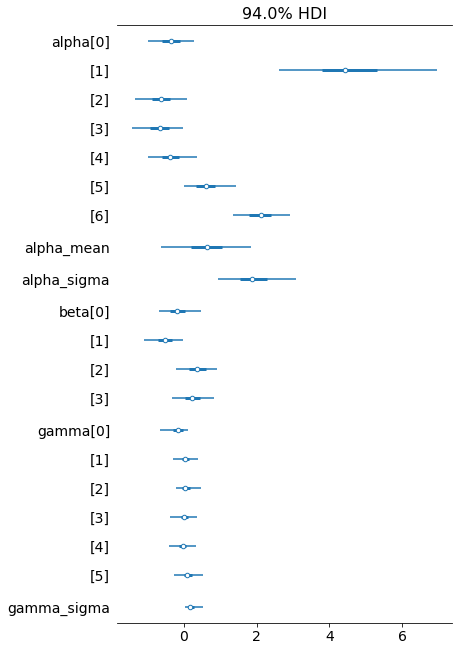

In [129]:
az13_4 = az.from_numpyro(m13_4)
az.plot_forest(az13_4)

In [130]:
# Devi's funnel

def model():
    v = numpyro.sample('v', dist.Normal(0,3))
    x = numpyro.sample('x', dist.Normal(0,jnp.exp(v)))

m13_5 = MCMC(NUTS(model), num_warmup=500, num_samples=500)
m13_5.run(random.PRNGKey(0))
m13_5.print_summary()

sample: 100%|██████████| 1000/1000 [00:04<00:00, 217.33it/s, 1 steps of size 2.29e-01. acc. prob=0.74]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         v      2.81      1.69      2.88      0.08      5.13     15.14      1.04
         x     -4.27     76.43     -0.12   -123.25    128.06     26.92      1.09

Number of divergences: 47


array([[<AxesSubplot:title={'center':'v'}>,
        <AxesSubplot:title={'center':'v'}>],
       [<AxesSubplot:title={'center':'x'}>,
        <AxesSubplot:title={'center':'x'}>]], dtype=object)

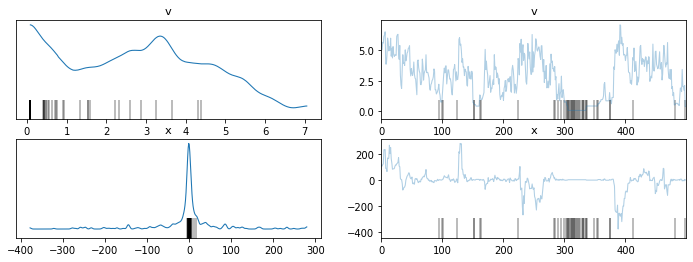

In [131]:
az13_5 = az.from_numpyro(m13_5)
az.plot_trace(az13_5)

In [133]:
# Non-centred parameterization

def model():
    v = numpyro.sample('v', dist.Normal(0,3))
    z = numpyro.sample('z', dist.Normal(0,1))
    x = numpyro.deterministic('x', z*jnp.exp(v))

m13_6 = MCMC(NUTS(model), num_warmup=500, num_samples=500)
m13_6.run(random.PRNGKey(0))
m13_6.print_summary()

sample: 100%|██████████| 1000/1000 [00:07<00:00, 126.65it/s, 7 steps of size 8.31e-01. acc. prob=0.93]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         v      0.26      2.86      0.15     -4.70      4.65    280.55      1.00
         z     -0.03      1.00     -0.03     -1.51      1.73    494.27      1.00

Number of divergences: 0


array([[<AxesSubplot:title={'center':'v'}>,
        <AxesSubplot:title={'center':'v'}>],
       [<AxesSubplot:title={'center':'x'}>,
        <AxesSubplot:title={'center':'x'}>],
       [<AxesSubplot:title={'center':'z'}>,
        <AxesSubplot:title={'center':'z'}>]], dtype=object)

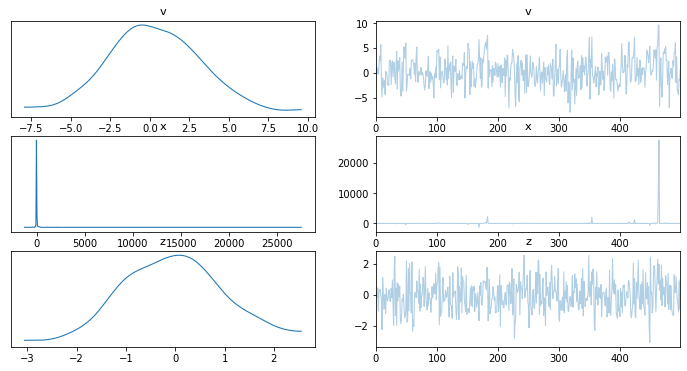

In [134]:
az13_6 = az.from_numpyro(m13_6)
az.plot_trace(az13_6)

array([[<AxesSubplot:ylabel='x'>, <AxesSubplot:>],
       [<AxesSubplot:xlabel='v', ylabel='z'>, <AxesSubplot:xlabel='x'>]],
      dtype=object)

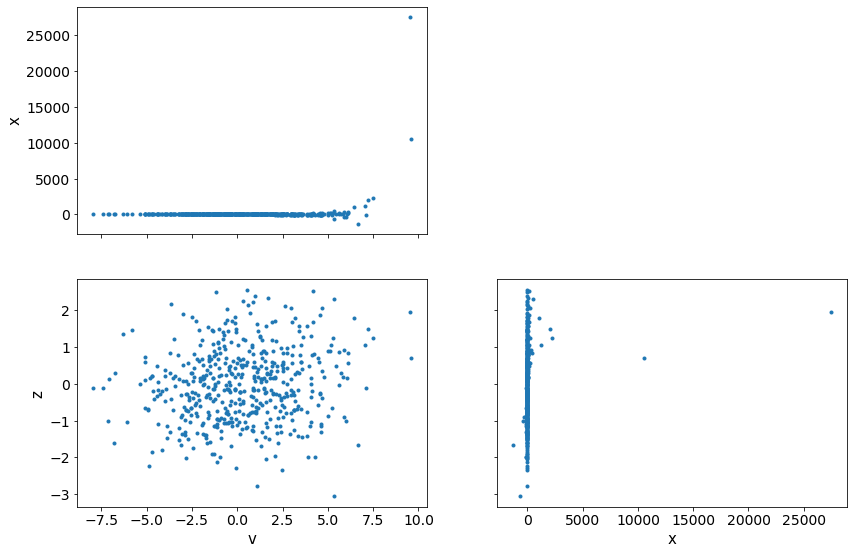

In [135]:
az.plot_pair(az13_6)

In [138]:
m13_6.get_samples().keys()

dict_keys(['v', 'x', 'z'])

In [147]:
az13_6['posterior'].squeeze()[['x', 'v']]

<xarray.Dataset>
Dimensions:  (draw: 500)
Coordinates:
    chain    int64 0
  * draw     (draw) int64 0 1 2 3 4 5 6 7 8 ... 492 493 494 495 496 497 498 499
Data variables:
    x        (draw) float32 0.4807 -0.1257 -0.1257 1.18 ... 0.254 -0.1891 2.303
    v        (draw) float32 1.382 -0.1473 -0.1473 0.9584 ... -1.272 -1.6 0.8259
Attributes:
    created_at:                 2022-02-03T11:46:34.147888
    arviz_version:              0.11.4
    inference_library:          numpyro
    inference_library_version:  0.8.0

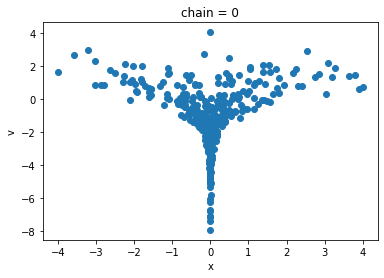

In [152]:
az13_6['posterior'].squeeze()[['x', 'v']].query(draw="(x > -4) and (x < 4)").plot.scatter(x='x', y='v')

In [ ]:
target_accept_prob=0.8

In [156]:
def model(actor, block, treatment, pulled_left=None):
    num_actors = len(np.unique(actor))
    num_blocks = len(np.unique(block))

    alpha_mean = numpyro.sample('alpha_mean', dist.Normal(0,1.5))
    alpha_sigma = numpyro.sample('alpha_sigma', dist.Exponential(1))
    std_alpha = numpyro.sample('std_alpha', dist.Normal(0, 1).expand([num_actors,]))
    alpha = numpyro.deterministic('alpha', alpha_mean + alpha_sigma*std_alpha)

    #gamma_mean = numpyro.sample('gamma_mean', dist.Normal(0,1))
    gamma_sigma = numpyro.sample('gamma_sigma', dist.Exponential(1))
    gamma_std = numpyro.sample('gamma_std', dist.Normal(0, 1).expand([num_blocks,]))
    gamma = numpyro.deterministic('gamma', gamma_sigma*gamma_std)

    beta = numpyro.sample('beta', dist.Normal(0,0.5).expand([4,]))

    logit = alpha[actor] + gamma[block] + beta[treatment]

    results = numpyro.sample('result', dist.BernoulliLogits(logit), obs=pulled_left)

m13_7 = MCMC(NUTS(model, target_accept_prob=0.9), num_warmup=500, num_samples=2000)
m13_7.run(random.PRNGKey(0), actor=d.actor.values-1, block=d.block.values-1, treatment=d.treatment.values, pulled_left=d.pulled_left.values)
m13_7.print_summary()

sample: 100%|██████████| 2500/2500 [00:10<00:00, 233.38it/s, 31 steps of size 9.76e-02. acc. prob=0.96] 



                   mean       std    median      5.0%     95.0%     n_eff     r_hat
   alpha_mean      0.64      0.74      0.63     -0.53      1.91    480.50      1.00
  alpha_sigma      2.01      0.66      1.88      1.04      2.88    610.05      1.00
      beta[0]     -0.12      0.31     -0.13     -0.66      0.34   1104.03      1.00
      beta[1]     -0.47      0.30     -0.48     -0.99     -0.00   1249.96      1.00
      beta[2]      0.40      0.30      0.41     -0.08      0.88    989.47      1.00
      beta[3]      0.28      0.30      0.28     -0.19      0.79   1062.72      1.00
  gamma_sigma      0.21      0.18      0.17      0.00      0.43   1058.61      1.00
 gamma_std[0]     -0.66      0.88     -0.69     -2.25      0.64   1574.42      1.00
 gamma_std[1]      0.14      0.85      0.14     -1.34      1.48   1982.22      1.00
 gamma_std[2]      0.21      0.85      0.21     -1.24      1.57   1599.10      1.00
 gamma_std[3]      0.04      0.84      0.04     -1.31      1.46   1628.37  

array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

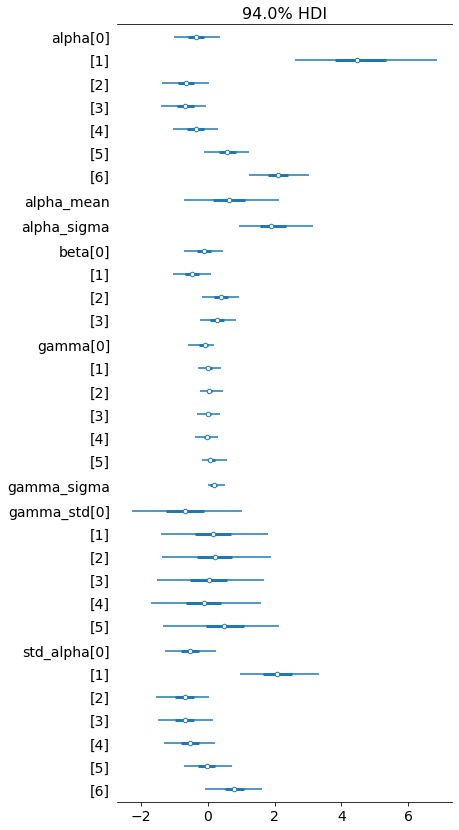

In [157]:
az13_7 = az.from_numpyro(m13_7)
az.plot_forest(az13_7)